In [75]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
import sqlalchemy

Importing the data from SQLite tables. 3 tables - all jobs, jobs with salaries, jobs with salaries and keywords. The keywords/search terms used for the analysis includes: Data Analyst, Data Scientist, Business Intelligence, Database Administrator.

In [115]:
engine = sqlalchemy.create_engine('sqlite:///JobData.db')

jobs = pd.read_sql('Select * FROM Jobs', engine, index_col='id')

jobs_keywords = pd.read_sql(""" Select 
t1.id, t1.job_title, t1.company, t1.location, t1.location_model, t1.jurisdiction, t1.city, t2.keyword
FROM Jobs t1 LEFT JOIN KeywordRef t2 ON t2.id = t1.id""", 
engine, index_col=['id', 'keyword'])


jobs_salaries = pd.read_sql(""" Select
t1.id, t1.job_title, t1.company, t1.location, t2.salary_type, t2.salary_period, t2.expected, t2.floor, t2.ceiling 
FROM Jobs t1 INNER JOIN Salaries t2 ON t1.id = t2.id""", 
engine, index_col='id')

jobs_salaries_keywords = pd.read_sql(""" Select 
t1.id, t1.job_title, t1.company, t1.location, t2.salary_type, t2.salary_period, t2.expected, t2.floor, t2.ceiling, t3.keyword 
FROM Jobs t1 INNER JOIN Salaries t2 ON t1.id = t2.id LEFT JOIN KeywordRef t3 ON t3.id = t1.id""", 
engine, index_col=['id', 'keyword'])


Overall job data seems clean and effectively populated for the most part. Rating's are null if not provided from job which indicates rating is sparely populated on job board. Working with a dataset of over 3000 jobs. 

In [4]:
jobs.head()

,job_title,company,location,rating_provided,rating,salary_provided,weblink,date_recorded,location_model,jurisdiction,city,country
id,,,,,,,,,,,,
cdc658d9990a63fc,Data Analyst (Banking Projects) - up to $62.00...,CorGTA Inc.,"Hybrid remote in Toronto, ON",n,NaN,y,https://ca.indeed.com/viewjob?jk=cdc658d9990a63fc,2023-11-17,Hybrid remote,ON,Toronto,Canada
cc8c9dc11f3c271f,"Business Analyst (Hybrid: North York, ON) - Re...",Enbridge Contingent Talent Community,"Hybrid remote in North York, ON",n,NaN,n,https://ca.indeed.com/viewjob?jk=cc8c9dc11f3c271f,2023-11-17,Hybrid remote,ON,North York,Canada
79507b61bd95323f,Pricing Analyst (FS/Tech/Furn),Staples Canada,"Mississauga, ON",n,NaN,n,https://ca.indeed.com/viewjob?jk=79507b61bd95323f,2023-11-17,Not Specified,ON,Mississauga,Canada
fb2e1282f0ec6e8e,Configuration Specialist/Functional Analyst,Procom,Remote in Ontario,n,NaN,n,https://ca.indeed.com/viewjob?jk=fb2e1282f0ec6e8e,2023-11-17,Remote,ON,Not Specified,Canada
1079d92e140e0d7f,Data Visualization Engineer,Motorola Solutions,"Remote in Markham, ON",n,NaN,y,https://ca.indeed.com/viewjob?jk=1079d92e140e0d7f,2023-11-17,Remote,ON,Markham,Canada


In [5]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2920 entries, cdc658d9990a63fc to eff3eeac0c6a2f1e
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job_title        2920 non-null   object 
 1   company          2920 non-null   object 
 2   location         2920 non-null   object 
 3   rating_provided  2920 non-null   object 
 4   rating           84 non-null     float64
 5   salary_provided  2920 non-null   object 
 6   weblink          2920 non-null   object 
 7   date_recorded    2920 non-null   object 
 8   location_model   2920 non-null   object 
 9   jurisdiction     2920 non-null   object 
 10  city             2920 non-null   object 
 11  country          2920 non-null   object 
dtypes: float64(1), object(11)
memory usage: 296.6+ KB


Most jobs pulled do not have a salary provided - just under 70%. 

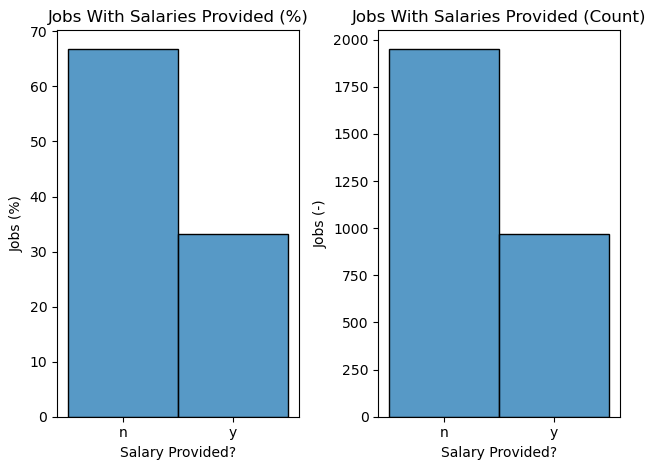

In [41]:
fig, axes = plt.subplots(1,2)

sns.histplot(data = jobs.sort_values(by = 'salary_provided'), x = 'salary_provided', stat = 'percent', ax=axes[0])
axes[0].set_title('Jobs With Salaries Provided (%)')
axes[0].set_xlabel("Salary Provided?")
axes[0].set_ylabel("Jobs (%)")

sns.histplot(data = jobs.sort_values(by = 'salary_provided'), x = 'salary_provided', ax=axes[1])
axes[1].set_title('Jobs With Salaries Provided (Count)')
axes[1].set_xlabel("Salary Provided?")
axes[1].set_ylabel("Jobs (-)")

plt.tight_layout()

plt.show()

The location model represents whether a job is remote, hybrid remote, or not specified. The not specified group is primarily on-site work but this is not factored out by the job board so it's grouped together. Over 60% of the jobs were part of the not specified group while the remaining amount was almost evenly split between hybrid and remote. The distribution is for a group of jobs that is typically very flexible in terms of location model. 

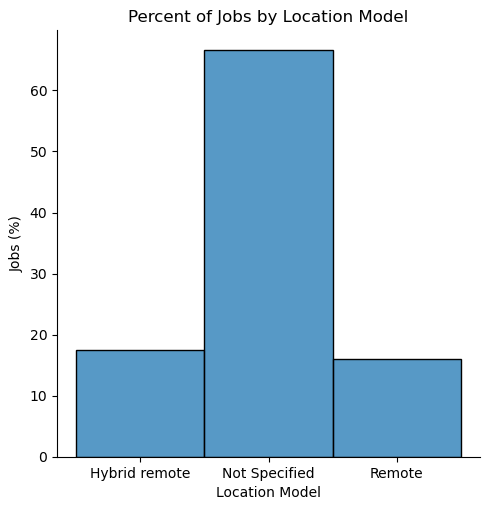

In [27]:
sns.displot(data = jobs, x = 'location_model', stat = 'percent')

plt.title("Percent of Jobs by Location Model")
plt.xlabel("Location Model")
plt.ylabel("Jobs (%)")

plt.show()

The next plot shows the distribution of jobs by province. It is effective at displaying where these subset of jobs tend to be located within the country on an absolute scale with Ontario having a very significant proportion of the results. British Columbia, Alberta, and Quebec round out the rest of the provinces with over 2% of the total jobs with the 4 provinces making up over 94% of the total jobs. 

The one thing this plot fails to show is how the jobs are distributed on a scale relative to population - Ontario has the highest population in Canada so from that perspective, it makes sense that it would have the most jobs as well. It would be interesting to see how well the provinces perform relative to their populations.

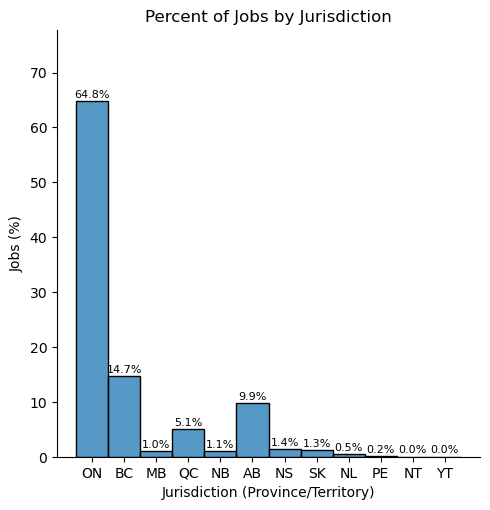

In [71]:
fg = sns.displot(data = jobs[jobs['jurisdiction'] != 'Not Specified'], x = 'jurisdiction', stat = 'percent')

for ax in fg.axes.ravel():
    for c in ax.containers:
        labels = [f'{v.get_height():0.1f}%' if v.get_height() > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, padding=1)
    
    ax.margins(y=0.2)

plt.title("Percent of Jobs by Jurisdiction")
plt.xlabel("Jurisdiction (Province/Territory)")
plt.ylabel("Jobs (%)")

plt.show()


In [43]:
#Count up jobs grouped by province and add a percent of total column
jobs_jurisdiction_grouped = pd.DataFrame(jobs.groupby('jurisdiction').size(), columns = ['job_count'])
jobs_jurisdiction_grouped['job_count_perc'] = jobs_jurisdiction_grouped['job_count'] / jobs_jurisdiction_grouped['job_count'].sum() * 100

#Remove the jobs that do not specify the jurisdiction within them
jobs_jurisdiction_grouped = jobs_jurisdiction_grouped[jobs_jurisdiction_grouped.index != 'Not Specified'].sort_values(by='job_count', ascending=False)


In [44]:
#Pull in csv file with populations by province and add a percent of total column
pop = pd.read_csv('Canada_Province_Population.csv', thousands=',', index_col = 'geography')

pop['population_perc'] = pop['population']/pop['population'].sum()*100

In [45]:
#Merge the two tables to analyze together
population_merged = pd.merge(left = jobs_jurisdiction_grouped, right = pop, how = 'inner', left_on=jobs_jurisdiction_grouped.index, right_on='jurisdiction').set_index('jurisdiction')[['job_count_perc','population_perc']]

The job and population data by province merged shows some interesting patterns between the two. Of the four provinces that makeup around 94% of the total job count, British Columbia and Alberta are very close in relative terms whereas Ontario and Quebec are far apart. 

Quebec appears to have a significantly smaller number of jobs relative to its population. Now it's important to note that for Quebec, this difference is likely impacted by the language search difference. When searching for jobs on the job board, a language must be provided to conduct the seach in which is English in this case. Quebec is primarily a French speaking province so it would be reasonable to assume that the jobs posted for that location would primarily be in French too. This makes it difficult to identify whether the difference found here is due to Quebec providing less jobs relatively or whether less jobs were searched for due to the highly impactful language of search. 

Although Ontario has the largest population proportionally at almost 39%, it has almost 60% of the proportional job count which indicates it is providing many more jobs on a relative scale. 

It is interesting to note that out of the remaining provinces and territories, very single one has a smaller job count relative to population. They appear much closer because the numbers are all small but the proportional differences between them are still significant.

From a purely quantitative perspective, Ontario likely provides the best opportunity to find a job within this subset of search terms. BC and Alberta are close with Quebec being difficult to interpret and the remaining provinces providing significantly less jobs relatively. 

In [46]:
population_merged

,job_count_perc,population_perc
jurisdiction,,
ON,59.828767,38.989374
BC,13.561644,13.770905
AB,9.109589,11.735989
QC,4.691781,22.079680
NS,1.267123,2.631281
SK,1.198630,3.007708
NB,1.027397,2.079345
MB,0.924658,3.615835
NL,0.479452,1.333431


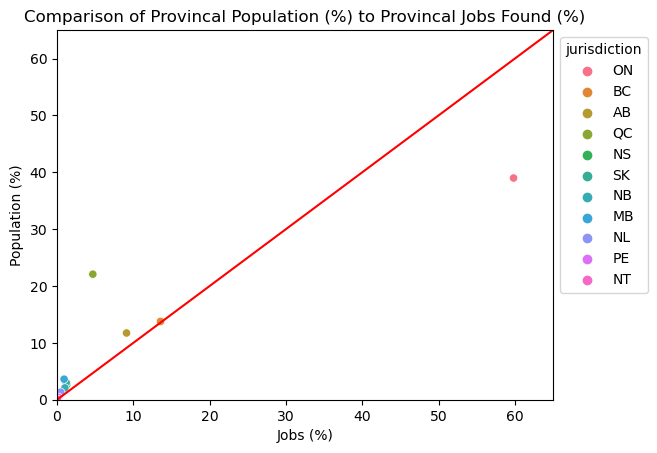

In [60]:
sns.scatterplot(data = population_merged, x='job_count_perc', y='population_perc', hue = population_merged.index)

axis_lim = 65

plt.xlim(0,axis_lim)
plt.ylim(0,axis_lim)

plt.plot([0,axis_lim], [0,axis_lim], color = 'red')

plt.legend(title='Jurisdiction', bbox_to_anchor=(1, 1), loc='upper left')

plt.title(label="Comparison of Provincal Population (%) to Provincal Jobs Found (%)")
plt.xlabel("Jobs (%)")
plt.ylabel("Population (%)")

plt.show()


So Ontario provides the most jobs in quantity, but is there a difference between the provinces related to the features of the jobs provided? 

Looking into salary transparency, Ontario appears to be very lacking by providing salaries for only around 28% of its jobs. This is much lower than both the other heavy hitters in BC and Alberta (Quebec will have discrepancies as highlighted in the previous section). It was interesting to note that BC provided salaries for around 60% of their jobs while every other region struggled to even approach the 50% barrier. What may be the reason for such an outlier? Either companies are being pressured to post the salaries from market pressures or from the government through legislation. 

Investigating legislation, CTV news has an article on provincal laws related to salary transparency by province and the associated legislation. BC has legislation that mandates salary ranges be provided for job postings, although there is no penalty for not abiding. Ontario and Manitoba have some proposed or unadopted legislations related to this but they are not currently active. NL and PEI both require salary ranges be provided in their jobs. The rest of the provinces have no related legislation.[1] Based on this, it appears that there is legislative pressure on BC to provide salaries which may be having an impact even with no penalties involved. However, it is likely not the only factor as NL and PEI had jobs with no salaries posted althought the sample size there was much lower. 

[1] https://www.ctvnews.ca/business/how-pay-transparency-laws-are-coming-into-effect-across-canada-1.6649868

In [62]:
jobs_jurisdiction_salary_grouped =pd.DataFrame(jobs[jobs['jurisdiction']!='Not Specified'].groupby(by=['jurisdiction', 'salary_provided']).size(), columns=['job_count']).reset_index().sort_values('job_count', ascending=False).reset_index(drop=True)

jobs_jurisdiction_salary_grouped.head()

,jurisdiction,salary_provided,job_count
0,ON,n,1258
1,ON,y,489
2,BC,y,238
3,AB,n,164
4,BC,n,158


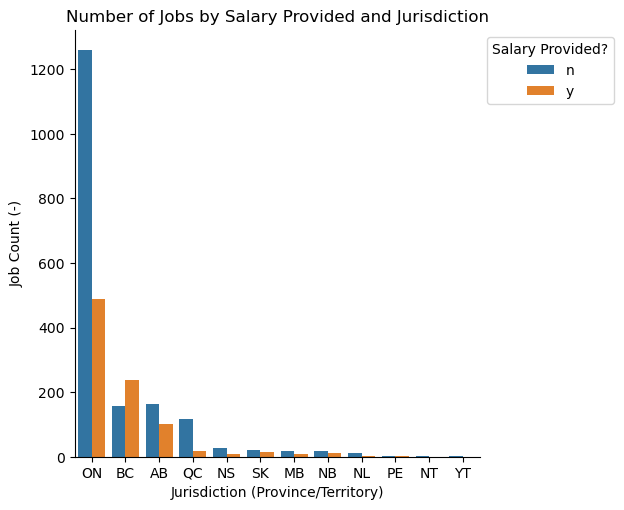

In [67]:
sns.catplot(data=jobs_jurisdiction_salary_grouped, kind = 'bar', 
            x = 'jurisdiction', 
            y = 'job_count',
            hue = 'salary_provided',
            legend = False
            )

plt.legend(title='Salary Provided?', bbox_to_anchor=(1, 1), loc='upper left')

plt.title("Number of Jobs by Salary Provided and Jurisdiction")
plt.xlabel("Jurisdiction (Province/Territory)")
plt.ylabel("Job Count (-)")

plt.show()

In [78]:
jobs_salaries.head()

,job_title,company,location,salary_type,salary_period,expected,floor,ceiling
id,,,,,,,,
cdc658d9990a63fc,Data Analyst (Banking Projects) - up to $62.00...,CorGTA Inc.,"Hybrid remote in Toronto, ON",range,hourly,61.00,60.00,62.00
1079d92e140e0d7f,Data Visualization Engineer,Motorola Solutions,"Remote in Markham, ON",range,yearly,75000.00,70000.00,80000.00
fbaa0c742c9095f4,Senior Data Analyst,Basis Technologies,"Remote in Toronto, ON",range,yearly,114000.00,84000.00,144000.00
edb18d98d48fef48,Data Analyst,ATW International Inc.,"York, ON",range,yearly,69826.00,40740.00,98912.00
6e63fd5ee73b1053,Data Developer and Analyst,Loyalist College,"Remote in Belleville, ON",range,hourly,44.39,41.12,47.67


In [79]:
jobs_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 968 entries, cdc658d9990a63fc to 156755c3658cab6d
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   job_title      968 non-null    object 
 1   company        968 non-null    object 
 2   location       968 non-null    object 
 3   salary_type    968 non-null    object 
 4   salary_period  968 non-null    object 
 5   expected       899 non-null    float64
 6   floor          672 non-null    float64
 7   ceiling        631 non-null    float64
dtypes: float64(3), object(5)
memory usage: 68.1+ KB


The left plot shows that most of the jobs have a 'range' or an 'expected' salary type. Range, as the name suggests, represents situations in which a salary range is provided in the job posting (ie. $30,000 - $40,000). The expected represents situations in which only a single salary value is provided. Floor and ceiling depict situations where job postings provide a single salary value, but also indicate that the value given represents the minimum salary value for the role (ie. "From $30,000) or the maximum salary value for the role (ie. "Up to $40,000). 

It is important to account for these situational differences in values provided to ensure comparisons are done on equal terms. In this analysis, an assumption is made that the range salary provided can be linerally interpolated between it's minimum and maximum values to provide a relatively accurate expected salary value. 

There are other assumptions that can be made related to the floor and ceiling salary values to try and approximate an expected value. However, such methods would would introduce additional approximation errors. Due to this and the fact that the ceiling and floor salary types represent a relatively small part of the total dataset (<10%), further analysis that compare different salaries will focus on the range and expected salary types only. 



The right plot shows that the majority of jobs with salaries provided do so at an hourly or yearly period. Since the sample size of the monthly, weekly and daily periods so small due to them being very rare, the remaining analysis focuses on hourly and yearly salaries provided only.  

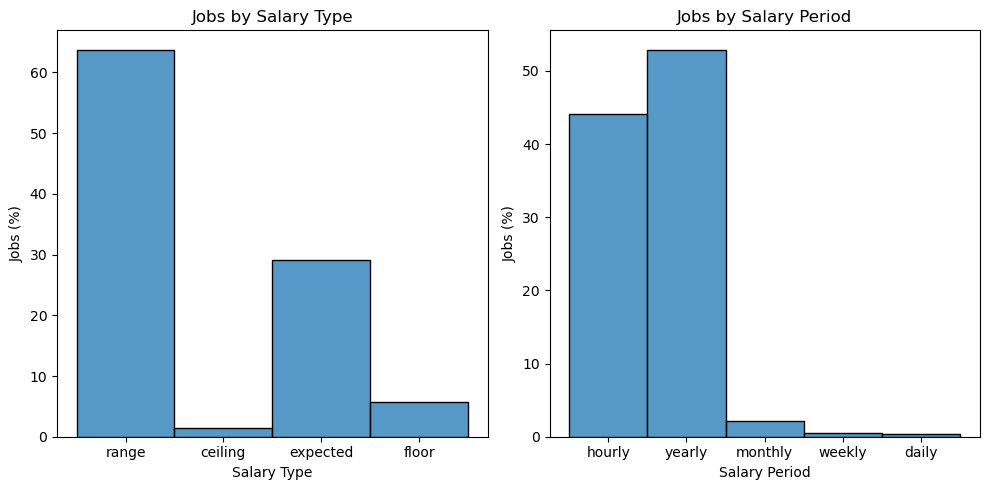

In [72]:
fig, axes = plt.subplots(1,2, figsize = (10,5))

sns.histplot(data = jobs_salaries, x = 'salary_type', stat = 'percent', ax = axes[0])
axes[0].set_title('Jobs by Salary Type')
axes[0].set_xlabel("Salary Type")
axes[0].set_ylabel("Jobs (%)")

sns.histplot(data = jobs_salaries, x = 'salary_period', stat = 'percent', ax = axes[1])
axes[1].set_title('Jobs by Salary Period')
axes[1].set_xlabel("Salary Period")
axes[1].set_ylabel("Jobs (%)")

plt.tight_layout()

The plot below helps visualize whether certain keywords had more transparency and flexibility for location model than others. There are differences that can be seen but they are relatively minor. 

Database administrator has the higest percent of jobs 'not specified'. Data analyst has a slightly higher percent than business intelligence and data scientist, which are both relatively close. The main difference between data scientist and business intelligence is that data scientist has a higher proportion of jobs as 'remote' whereas business intelligence has a higher proportion of jobs as 'hybrid remote'. 

Although the differences aren't very large, the flexibility of the roles based on this data would rank as data scientist > business intelligence > data analyst > database administrator. 

In [149]:
jobs_keywords.head()

,,job_title,company,location,location_model,jurisdiction,city
id,keyword,,,,,,
cdc658d9990a63fc,data analyst,Data Analyst (Banking Projects) - up to $62.00...,CorGTA Inc.,"Hybrid remote in Toronto, ON",Hybrid remote,ON,Toronto
cc8c9dc11f3c271f,data analyst,"Business Analyst (Hybrid: North York, ON) - Re...",Enbridge Contingent Talent Community,"Hybrid remote in North York, ON",Hybrid remote,ON,North York
79507b61bd95323f,data analyst,Pricing Analyst (FS/Tech/Furn),Staples Canada,"Mississauga, ON",Not Specified,ON,Mississauga
fb2e1282f0ec6e8e,data analyst,Configuration Specialist/Functional Analyst,Procom,Remote in Ontario,Remote,ON,Not Specified
1079d92e140e0d7f,data analyst,Data Visualization Engineer,Motorola Solutions,"Remote in Markham, ON",Remote,ON,Markham


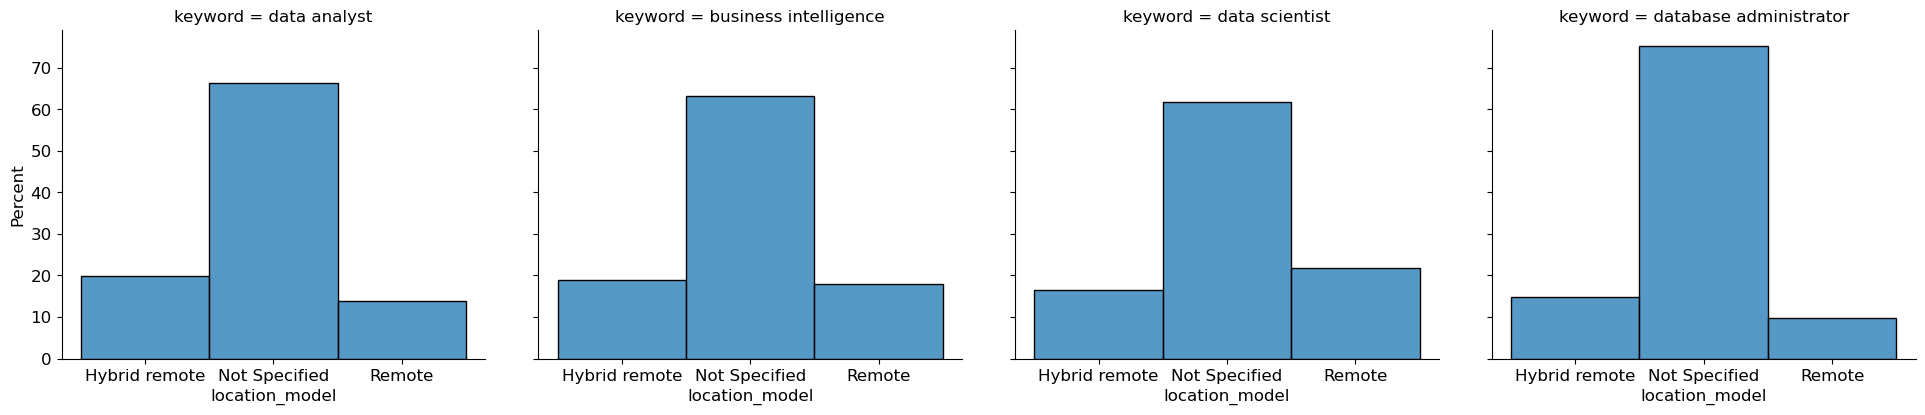

In [148]:
g = sns.FacetGrid(jobs_keywords.reset_index(), col = 'keyword')

g.map(sns.histplot, 'location_model', stat = 'percent')

g.fig.set_size_inches(20,5)

plt.show()

In [82]:
jobs_salaries_keywords.head(10)

job_title  \
id               keyword                                                                    
cdc658d9990a63fc data analyst           Data Analyst (Banking Projects) - up to $62.00...   
1079d92e140e0d7f data analyst                                 Data Visualization Engineer   
fbaa0c742c9095f4 business intelligence                                Senior Data Analyst   
                 data analyst                                         Senior Data Analyst   
                 data scientist                                       Senior Data Analyst   
edb18d98d48fef48 data analyst                                                Data Analyst   
6e63fd5ee73b1053 data analyst                                  Data Developer and Analyst   
44880ef6ce63c754 data analyst                                                Data Analyst   
197926fa0febf754 data analyst                                 Customer Experience Analyst   
f4832e487b08b713 data analyst                                                Data Analyst   

                                                                 company  \
id               keyword                                                   
cdc658d9990a63fc data analyst                                CorGTA Inc.   
1079d92e140e0d7f data analyst                         Motorola Solutions   
fbaa0c742c9095f4 business intelligence                Basis Technologies   
                 data analyst                         Basis Technologies   
                 data scientist                       Basis Technologies   
edb18d98d48fef48 data analyst                     ATW International Inc.   
6e63fd5ee73b1053 data analyst                           Loyalist College   
44880ef6ce63c754 data analyst           BC First Nations Justice Council   
197926fa0febf754 data analyst                 Toronto Transit Commission   
f4832e487b08b713 data analyst                                   Plaxonic   

                                                            location  \
id               keyword                                               
cdc658d9990a63fc data analyst           Hybrid remote in Toronto, ON   
1079d92e140e0d7f data analyst                  Remote in Markham, ON   
fbaa0c742c9095f4 business intelligence         Remote in Toronto, ON   
                 data analyst                  Remote in Toronto, ON   
                 data scientist                Remote in Toronto, ON   
edb18d98d48fef48 data analyst                               York, ON   
6e63fd5ee73b1053 data analyst               Remote in Belleville, ON   
44880ef6ce63c754 data analyst             Remote in West Kelowna, BC   
197926fa0febf754 data analyst                            Toronto, ON   
f4832e487b08b713 data analyst                        Mississauga, ON   

                                       salary_type salary_period   expected  \
id               keyword                                                      
cdc658d9990a63fc data analyst                range        hourly      61.00   
1079d92e140e0d7f data analyst                range        yearly   75000.00   
fbaa0c742c9095f4 business intelligence       range        yearly  114000.00   
                 data analyst                range        yearly  114000.00   
                 data scientist              range        yearly  114000.00   
edb18d98d48fef48 data analyst                range        yearly   69826.00   
6e63fd5ee73b1053 data analyst                range        hourly      44.39   
44880ef6ce63c754 data analyst                range        yearly   70000.00   
197926fa0febf754 data analyst                range        yearly   79570.50   
f4832e487b08b713 data analyst              ceiling        yearly        NaN   

                                           floor    ceiling  
id               keyword                                     
cdc658d9990a63fc data analyst              60.00      62.00  
1079d92e140e0d7f data analyst           70000.00  

In [28]:
jobs_salaries_keywords_hourly = jobs_salaries_keywords[jobs_salaries_keywords['salary_period'] == 'hourly']
jobs_salaries_keywords_yearly = jobs_salaries_keywords[jobs_salaries_keywords['salary_period'] == 'yearly']

**Yearly Salary Period**

Data Scientist keyword yearly salary distribution is shifted much further to the right than the other three keywords - this is expected as the educational requirements and skillsets expected for these jobs would typically be more difficult to get. 

The distributions tend to have a positive skew due to cutoff of minimum salary and high salary jobs being available to some degree for each keyword. There are some small peaks on the right as well. Would be interesting to further separate by senority of job and/or years of experience to factor that as part of the distributions. 

The peaks between data analyst and business intelligence are fairly close, but the business intelligence roles have a longer right tails - about falling close to halfway between data analyst and data scientist. 

The peak of the database administrator yearly salary is much wider than that of data analyst and business intelligence. The peak starts at a much lower salary but ends slighly after their peaks. The right skew follows a similar patter to data analyst, but the database administrator has a higher salary for its later peak. 

**Hourly Salary Period**

Data scientist and business intelligence keywords have much fewer roles with an hourly salary period - pattern not very clear due to small sample size relative to all the keywords. 

Database administrators and data analyst have a very similar and sharp peak. Interestingly, the database administrator keyword have a much higher secondary peak at the very start of the salary range than data analyst. 


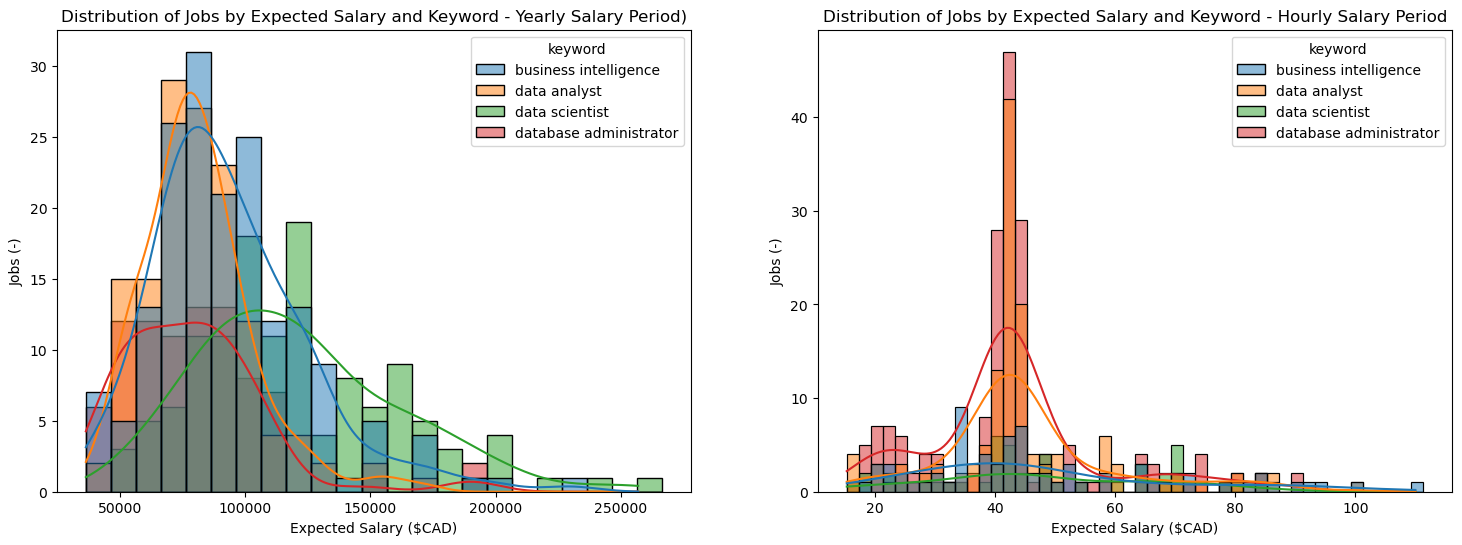

In [101]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.histplot(
    data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'].sort_values(by = 'keyword'), x='expected', hue = 'keyword', kde = True, binwidth = 10000, ax=axes[0])

axes[0].set_title("Distribution of Jobs by Expected Salary and Keyword - Yearly Salary Period")
axes[0].set_xlabel("Expected Salary ($CAD)")
axes[0].set_ylabel("Jobs (-)")

sns.histplot(
    data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='hourly'].sort_values(by = 'keyword'), x='expected', hue = 'keyword', kde = True, binwidth = 2, ax=axes[1])

axes[1].set_title("Distribution of Jobs by Expected Salary and Keyword - Hourly Salary Period")
axes[1].set_xlabel("Expected Salary ($CAD)")
axes[1].set_ylabel("Jobs (-)")

plt.show()

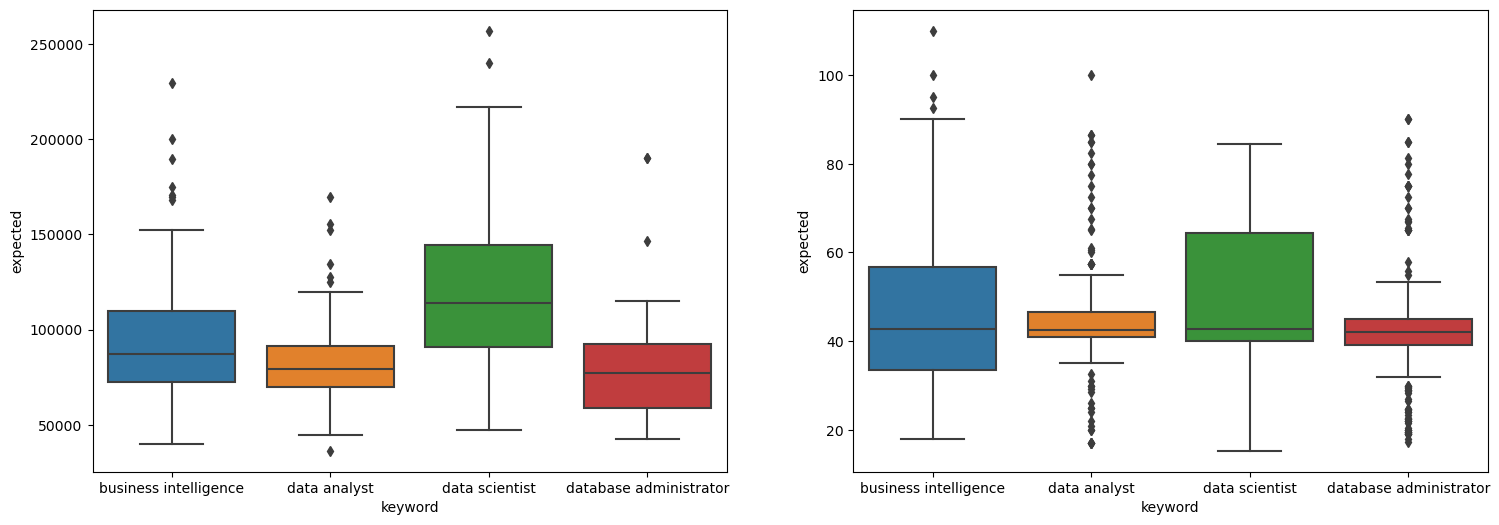

In [105]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

sns.boxplot(data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'].reset_index().sort_values(by = 'keyword'), x='keyword', y='expected', ax=axes[0])

sns.boxplot(data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='hourly'].reset_index().sort_values(by = 'keyword'), x='keyword', y='expected', ax=axes[1])

plt.show()

Box plots show the salary distributions in a slightly different way but the patterns line up similarily to what is seen in the histograns. 

The numerical median values shown provides a more quantitative context to the peak value patters seen earlier. 

The median values for the hourly salaries are very close for all the jobs. However, in the box plot, some of the context relating to the sample size of jobs providing this distribution is lost. The multi-modal nature of the plots for data analyst and database administrator with the very high and narrow single peak is contibuting to the number of outliers seens in the boxplots. 

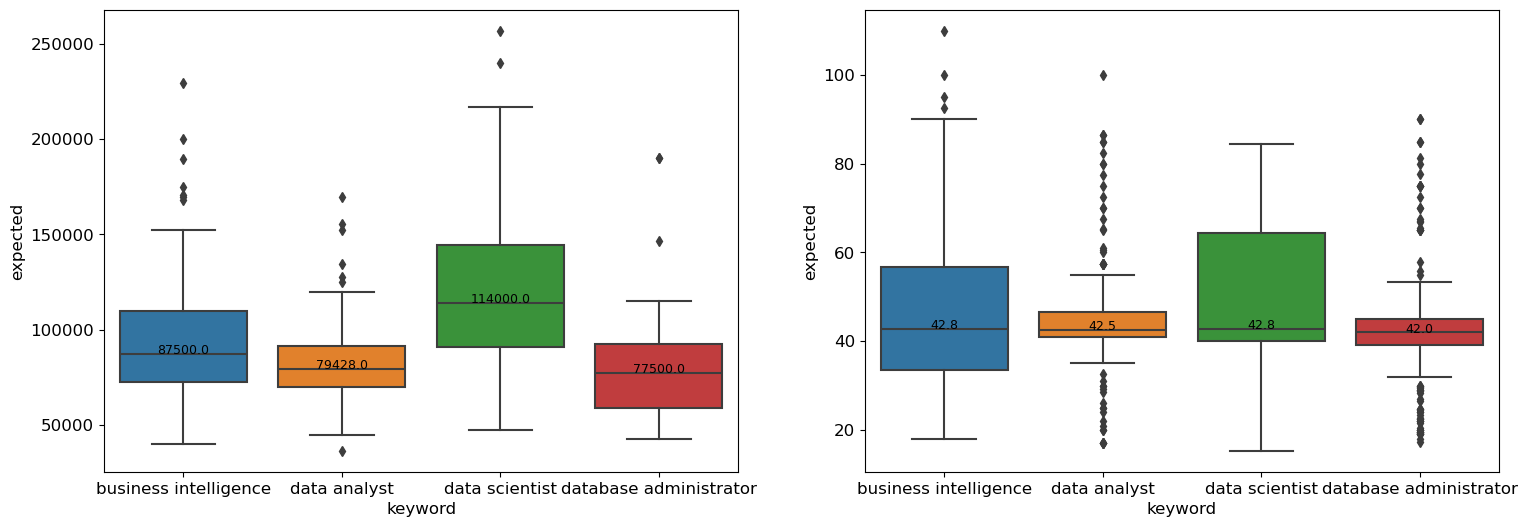

In [161]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

sns.boxplot(data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'].reset_index().sort_values(by = 'keyword'), x='keyword', y='expected', ax=axes[0])
for index, row in jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'].groupby(['keyword'])['expected'].median().reset_index().iterrows():
    axes[0].text(index, row['expected'], round(row['expected'], 0), color='black', ha="center", fontsize = 9)

sns.boxplot(data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='hourly'].reset_index().sort_values(by = 'keyword'), x='keyword', y='expected', ax=axes[1])
for index, row in jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='hourly'].groupby(['keyword'])['expected'].median().reset_index().iterrows():
    axes[1].text(index, row['expected'], round(row['expected'], 1), color='black', ha="center", fontsize = 9)



This analysis is able to show general trends relating to features of jobs available as searched through job boards - Indeed in this case. The advantage of using a tool like this to visualize and analyze these trends are manyfold:

1. The analysis can be curated to the specific keywords one is interested in. 
2. The trends are based on the current market conditions of the role. 
3. There is no questioning of where the data is coming from or intentions - which can be a factor when looking up values or trends for roles online. 